### Here is contained all data processing code for my master Thesis

## Setup

In [124]:
import re,os,glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statistics
from collections import defaultdict
import numpy as np
# re patterns
base_save_dir="results/wildcards/"
base_save_dir_thesis="../latex/results/"
base_dir=os.path.join("data/wildcards/last")

file_pattern= r'(\w+)_(\w+)_(\w+)_(\d+).data'
matching_files = glob.glob(f"{base_dir}/*")

pub_pattern = r'cycles: (\d+) instruction: (\d+) start_ns: (\d+) end_ns: (\d+) start_s: (\d+) end_s: (\d+)'
sub_pattern = r'(\d+) received_s: (\d+) received_ns: (\d+)'


# Calculate the IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

def timespec_difference(start_s, start_ns, end_s, end_ns):
    time1_merged= start_s *1e6 + start_ns / 1e3
    time2_merged= end_s *1e6 + end_ns / 1e3
    return (time2_merged - time1_merged)

- boxplot
- metrics in S
- check consistency of all data

real r505n006    , Rank 001: seconds 7193676, nanosecond 80357538
dummy r505n007    , Rank 002: seconds 16777072, nanosecond 673656936
pub r505n005    , Rank 000: seconds 7260791, nanosecond 680214187

## Retrive data

In [125]:
sequence = [0,1,2,4,6,8,12,16]
protocols = ["udp", "udpM"] #For now considering only udp

sent_data={}
received_negative={}
received_data={}
sent_data_time={}
for prot in protocols:
    sent_data[prot]={}
    received_data[prot]={}
    sent_data_time[prot]={}
    for seq in sequence:
        sent_data[prot][seq]=[]
        received_data[prot][seq]=[]
        sent_data_time[prot][seq]=[]

for files in matching_files:
    match_file = re.search(file_pattern, files)
    if match_file:
        actor,protocol,_,testN = match_file.groups()
        if int(testN) not in sequence: continue
        if actor == "pub": #pubs
            with open(files, 'r') as file: 
                for line in file:
                    match = re.search(pub_pattern, line)
                    if match:
                        cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                        sent_data[protocol][int(testN)].append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
                        diff = timespec_difference(int(start_s), int(start_ns) , int(end_s) ,int(end_ns) ) /4
                        sent_data_time[protocol][int(testN)].append(diff)
                    else: print("NOT MATCH PUB")
        else: # subs
            with open(files, 'r') as file: 
                for content in file:
                    match = re.search(sub_pattern, content)
                    if match:
                        line_n, received_s, received_ns = match.groups()
                        start_s,start_ns = ((sent_data[protocol][int(testN)][int(line_n)][2], sent_data[protocol][int(testN)][int(line_n)][3]))
                        diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns)) / 2
                        received_data[protocol][int(testN)].append(diff)


### Cleaning data

In [126]:
column_time_avg ={}
column_time_cleaned = {}
column_timesent_avg ={}
column_timesent_cleaned = {}
for prots in protocols:
    column_time_cleaned[prots]={}
    column_time_avg[prots]={}
    column_timesent_cleaned[prots]={}
    column_timesent_avg[prots]={}
    for seq in sequence:
        try:
            lower_bound, upper_bound = calculate_iqr(received_data[prots][seq])
            column_time_cleaned[prots][seq] = [x for x in received_data[prots][seq] if lower_bound <= x <= upper_bound]
            column_time_avg[prots][seq]=np.average(column_time_cleaned[prots][seq])
            #print(column_time_avg[prots][seq])
        except: pass
    for seq in sequence:
        try:
            lower_bound, upper_bound = calculate_iqr(sent_data_time[prots][seq])
            column_timesent_cleaned[prots][seq] = [x for x in sent_data_time[prots][seq] if lower_bound <= x <= upper_bound]
            column_timesent_avg[prots][seq]=np.average(column_timesent_cleaned[prots][seq])
            #print(column_time_avg[prots][seq])
        except: pass
print(column_time_avg)

{'udp': {0: 156.77539608908515, 1: 172.47772446256178, 2: 175.75817277590355, 4: 166.4419315399938, 6: 164.878072355253, 8: 167.49522461834627, 12: 166.83505394830138, 16: 162.11726237094646}, 'udpM': {0: 106.95198765373733, 1: 104.96892251285949, 2: 101.17568061139539, 4: 103.40823458622742, 6: 97.03223191636444, 8: 99.31635758850902, 12: 104.24159915685337, 16: 102.25667223051435}}


## Sending - Receiving time

### Bar Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


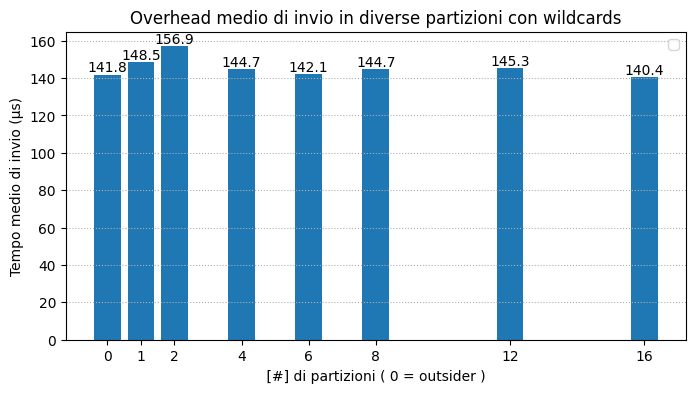

In [132]:
plt.figure(figsize=(8, 4))

avg_data = [column_timesent_avg["udp"][seq] for seq in sequence]

bars= plt.bar(sequence,avg_data)
# Add values inside each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}', ha='center', va='bottom')
plt.xlabel(" [#] di partizioni ( 0 = outsider ) ")
plt.xticks(sequence)
plt.ylabel('Tempo medio di invio (μs)')

plt.legend()
plt.title("Overhead medio di invio in diverse partizioni con wildcards")
plt.grid(axis='y', linestyle=':')
#plt.savefig(f"{base_save_dir_thesis}test2_wildcards.png")

### Box Plot

maxlenght is 8


ValueError: Dimensions of labels and X must be compatible

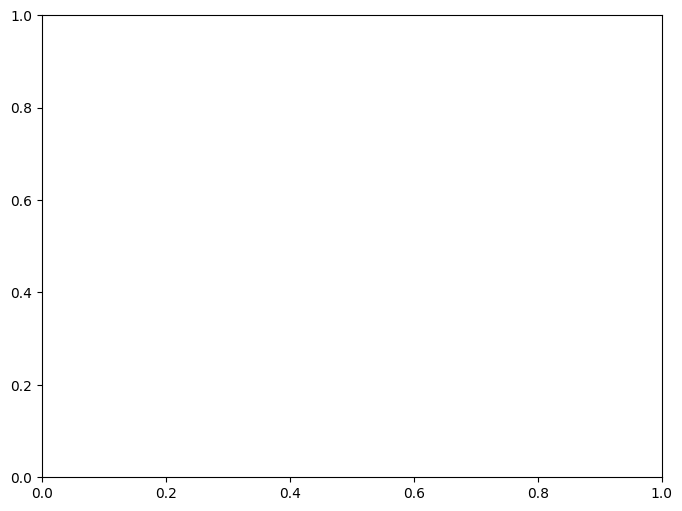

In [128]:
maxlenght = max(len(data) for data in column_time_cleaned.values())
print("maxlenght is {}".format(maxlenght))

# Need to allineate all data
for ngroup, data in column_time_cleaned.items():
    if len(data) < maxlenght:
        print("Fixing dimension of : ",ngroup,len(data),maxlenght)
        column_time_cleaned[ngroup] += [column_averages[ngroup]] * (maxlenght-len(data))
        #print([column_averages[ngroup]]* (maxlenght-len(data)))

plt.figure(figsize=(8, 6))
plt.boxplot(x=column_time_cleaned.values(),data=column_time_cleaned.keys(),labels=sequence)
plt.title("Average receiving time (μs) vs dynamic partition")
plt.ylabel("Time(μs)")

print(column_time_cleaned.keys())

print(base_dir.split('/')[0])
plt.savefig(f"{base_save_dir}boxplot_sendingreceiving_{base_dir.split('/')[2]}.png")

plt.show()



### Uncleaned data

maxlenght is 47494
Fixing dimension of :  1 47166 47494
Fixing dimension of :  4 47252 47494
Fixing dimension of :  6 47348 47494
Fixing dimension of :  8 47350 47494
Fixing dimension of :  12 47200 47494
Fixing dimension of :  16 47363 47494
dict_keys([1, 2, 4, 6, 8, 12, 16])
data


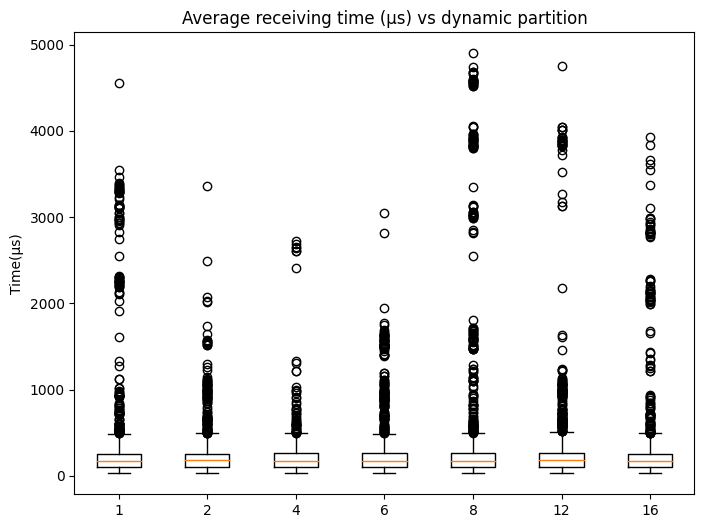

In [ ]:
maxlenght = max(len(data) for data in column_time.values())
print("maxlenght is {}".format(maxlenght))

# Need to allineate all data
for prots, data in column_time.items():
    if len(data) < maxlenght:
        print("Fixing dimension of : ",prots,len(data),maxlenght)
        column_time[prots] += [column_averages[prots]] * (maxlenght-len(data))
        #print([column_averages[prots]]* (maxlenght-len(data)))

plt.figure(figsize=(8, 6))
plt.boxplot(x=column_time.values(),data=column_time.keys(),labels=sequence)
plt.title("Average receiving time (μs) vs dynamic partition")
#plt.xlabel("different protocols")
plt.ylabel("Time(μs)")

print(column_time.keys())

print(base_dir.split('/')[0])
plt.show()



## Only sending

### Clean data

In [ ]:
column_time_sent = {}
column_time_sent_dummy=[]
# Convert data to timespec
for seq in sent_data_time:
    list_difference=[]
    nlen= len(sent_data_time[seq])
    for cycle_data in sent_data_time[seq]:
        list_difference.append(cycle_data[0] * 1e6 + cycle_data[1] / 1e3) # time in second
    column_time_sent[seq]=list_difference
    print(np.average(column_time_sent[seq]))

for cycle_data in sent_data_time_dummy:
    column_time_sent_dummy.append( cycle_data[0] * 1e6 + cycle_data[1] / 1e3 )# time in second

# Remove outliers
column_time_sent_cleaned = {}

for seq, data in column_time_sent.items():
    lower_bound, upper_bound = calculate_iqr(data)
    column_time_sent_cleaned[seq] = [x for x in data if lower_bound <= x <= upper_bound]

lower_bound, upper_bound = calculate_iqr(column_time_sent_dummy)
column_time_sent_dummy_cleaned = [x for x in column_time_sent_dummy if lower_bound <= x <= upper_bound]

348.960035
341.400679
349.69290799999993
346.22424899999993
350.797304
353.690916
338.471614


<Figure size 1200x600 with 0 Axes>

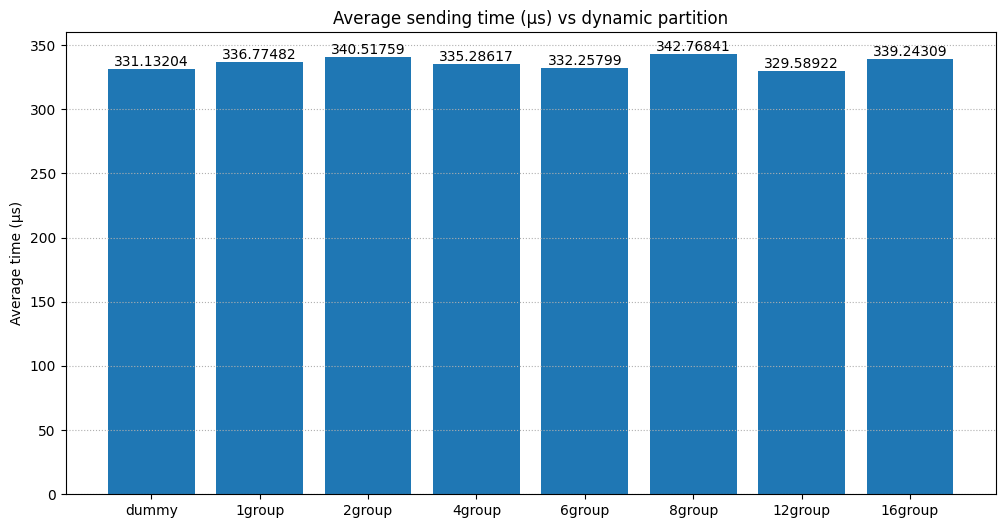

In [ ]:
# Prepare data for bar plot
column_averages={}
for ngroup, data in column_time_cleaned.items():
    column_averages[ngroup] = np.average(column_time_sent_cleaned[ngroup])
column_averages[0] = np.average(column_time_sent_dummy_cleaned)

bar_colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green','tab:purple','tab:pink','tab:cyan','tab:olive']

plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(12,6))
bars= ax.bar(bar_labels,column_averages.values())
# Add values inside each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')
# plt.xlabel(" # of partition ( 0 = dummy ) ")
plt.ylabel("Average time (μs)")
# plt.legend()
plt.title("Average sending time (μs) vs dynamic partition")
plt.grid(axis='y', linestyle=':')
plt.savefig(f"{base_save_dir}barplots_sending_{base_dir.split('/')[2]}.png")

plt.show()

## Instruction vs TSC

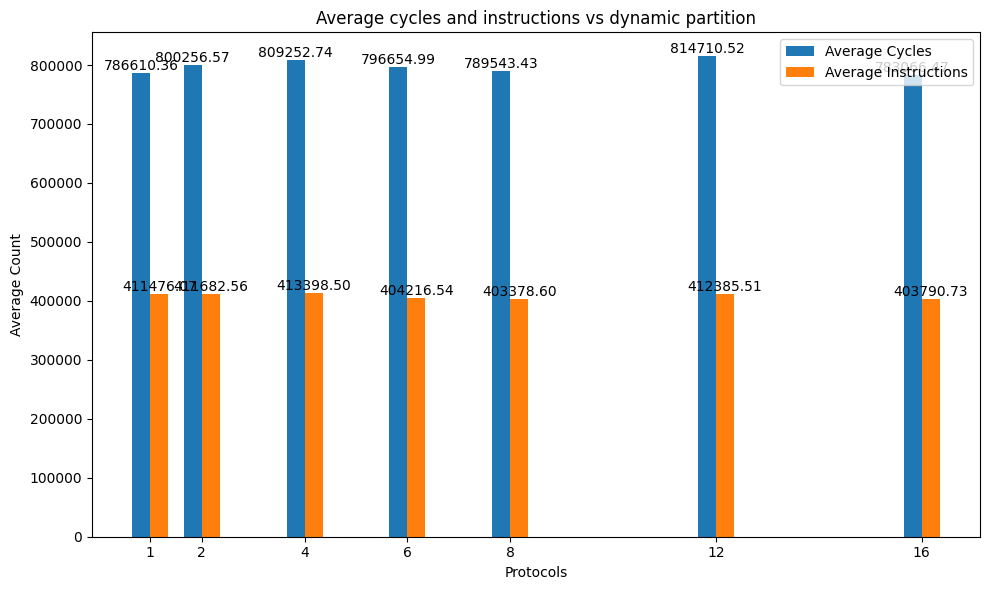

In [ ]:
cycles,cycles_cleaned,instructions_cleaned={},{},{}
instructions={}
average_cycles={}
average_instructions={}
for seq in sequence:
    cycles[seq] = [data[0] for data in sent_data[seq]]
    instructions[seq] = [data[1] for data in sent_data[seq]]
    lower_bound, upper_bound = calculate_iqr(cycles[seq])
    cycles_cleaned[seq] = [x for x in cycles[seq] if lower_bound <= x <= upper_bound]
    lower_bound, upper_bound = calculate_iqr(instructions[seq])
    instructions_cleaned[seq] = [x for x in instructions[seq] if lower_bound <= x <= upper_bound]
    average_cycles[seq] = sum(cycles_cleaned[seq]) / len(cycles_cleaned[seq])
    average_instructions[seq] = sum(instructions_cleaned[seq]) / len(instructions_cleaned[seq])

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = sequence
barsc = plt.bar(x, average_cycles.values(), width=bar_width, label='Average Cycles')
barsi=plt.bar([i + bar_width for i in x], average_instructions.values(), width=bar_width, label='Average Instructions')
plt.xticks([i + bar_width / 2 for i in x], sequence)
plt.xlabel('Protocols')
plt.ylabel('Average Count')
for bar in barsc:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
for bar in barsi:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.title("Average cycles and instructions vs dynamic partition")
plt.legend()
plt.tight_layout()
plt.show()

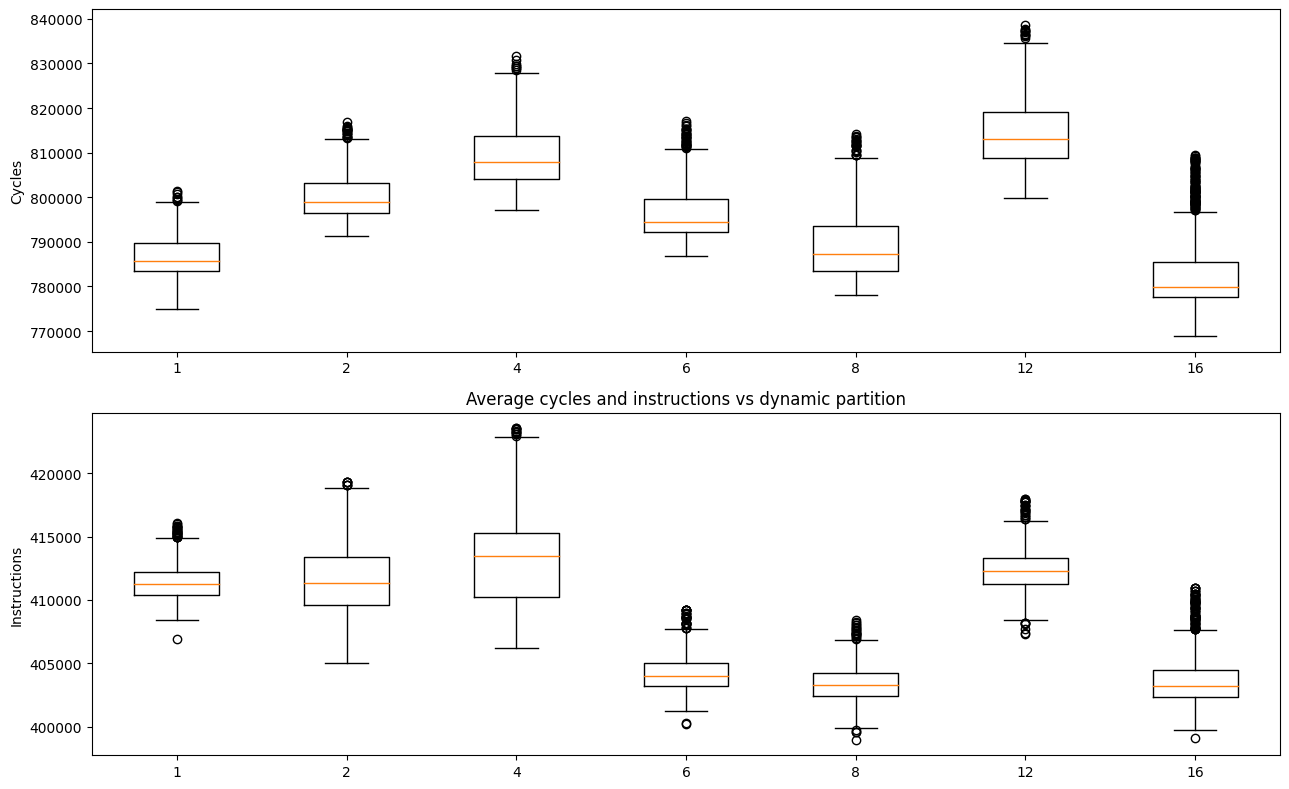

In [ ]:
fig, axs = plt.subplots(2, figsize=(13, 8))
plt.title("Average cycles and instructions vs dynamic partition")

# Box plot for cycles
axs[0].boxplot(cycles_cleaned.values())
axs[0].set_xticklabels(cycles_cleaned.keys())
axs[0].set_ylabel('Cycles')

# Box plot for instructions
axs[1].boxplot(instructions_cleaned.values())
axs[1].set_xticklabels(instructions_cleaned.keys())
axs[1].set_ylabel('Instructions')

plt.tight_layout()
plt.savefig(f"{base_save_dir}boxplots_cyclesinstr_{base_dir.split('/')[2]}.png")

plt.show()
